In [ ]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
import seaborn as sns
from matplotlib import pyplot as plt
from pyspark.sql import Window
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, ArrayType, DoubleType, BooleanType

sc = SparkSession.builder.appName("Recommendations").config("spark.sql.files.maxPartitionBytes", 5000000).getOrCreate()
spark = SparkSession(sc)

In [ ]:
articles = spark.read.option("header",True) \
                .csv("/content/drive/MyDrive/articles.csv")
customers = spark.read.option("header",True) \
                .csv("/content/drive/MyDrive/customers.csv")
transactions = spark.read.option("header",True) \
                .csv("/content/drive/MyDrive/transactions.csv")

In [ ]:
articles = articles\
    .selectExpr('cast (article_id as int) article_id', 'cast (product_type_no as int) product_type_no', 'cast (graphical_appearance_no as int) graphical_appearance_no',
                'cast (colour_group_code as int) colour_group_code ','cast (perceived_colour_value_id as int) perceived_colour_value_id',
                'cast (department_no as int) department_no',  'cast (index_group_no as int) index_group_no',
                'cast (section_no as int) section_no', 'cast (garment_group_no as int) garment_group_no')\
    .dropDuplicates()

articles.show(10)

+----------+---------------+-----------------------+-----------------+-------------------------+-------------+--------------+----------+----------------+
|article_id|product_type_no|graphical_appearance_no|colour_group_code|perceived_colour_value_id|department_no|index_group_no|section_no|garment_group_no|
+----------+---------------+-----------------------+-----------------+-------------------------+-------------+--------------+----------+----------------+
| 257430026|            253|                1010001|               73|                        4|         7922|             4|        79|            1017|
| 265071034|            255|                1010016|               81|                        3|         8768|             4|        72|            1002|
| 291338033|            304|                1010016|               10|                        3|         7921|             4|        79|            1021|
| 302334005|             67|                1010016|                9|      

In [ ]:
customers = customers\
    .fillna({'age': '25'})\
    .drop('FN', 'Active', 'club_member_status', 'fashion_news_frequency', 'postal_code')

In [ ]:
start_date = '2020-07-22'

min_week = 1
max_week = 9
application_week = max_week + 1
#week: changed to tuesday
print(application_week)

10


In [ ]:
transactions = transactions\
    .withColumn('article_id', transactions['article_id'].cast(IntegerType()))\
    .filter(F.col('t_dat') >= start_date)\
    .withColumn('week', F.when((F.col('t_dat') >= '2020-09-16') & (F.col('t_dat') <= '2020-09-22'), 9)
                         .when((F.col('t_dat') >= '2020-09-09') & (F.col('t_dat') <= '2020-09-15'), 8)
                         .when((F.col('t_dat') >= '2020-09-02') & (F.col('t_dat') <= '2020-09-08'), 7)
                         .when((F.col('t_dat') >= '2020-08-26') & (F.col('t_dat') <= '2020-09-01'), 6)
                         .when((F.col('t_dat') >= '2020-08-19') & (F.col('t_dat') <= '2020-08-25'), 5)
                         .when((F.col('t_dat') >= '2020-08-12') & (F.col('t_dat') <= '2020-08-18'), 4)
                         .when((F.col('t_dat') >= '2020-08-05') & (F.col('t_dat') <= '2020-08-11'), 3)
                         .when((F.col('t_dat') >= '2020-07-29') & (F.col('t_dat') <= '2020-08-04'), 2)
                         .when((F.col('t_dat') >= '2020-07-22') & (F.col('t_dat') <= '2020-07-28'), 1)
                        .otherwise(999))\
    .drop('t_dat', 'price', 'sales_channel_id')\
    .orderBy(['week', 'customer_id'], ascending=True)

transactions.show(10)
# code to generate unique transaction id:
# .withColumn('t_id', F.concat_ws('_',transactions.t_dat, transactions.customer_id))\

+--------------------+----------+----+
|         customer_id|article_id|week|
+--------------------+----------+----+
|0001076e215991bad...| 843373003|   1|
|0006bb0fad5c49341...| 802979001|   1|
|0006bb0fad5c49341...| 717370001|   1|
|000c886e014a122bd...| 554598047|   1|
|0010bb1c4a9c39adb...| 816166004|   1|
|001bf9b4bb1cbd8e2...| 828067003|   1|
|001c1f8d70782f450...| 701085019|   1|
|0028c4674e52ba2e3...| 809752005|   1|
|00357b192b81fc832...| 906822002|   1|
|003a8444fce07c006...| 852940004|   1|
+--------------------+----------+----+
only showing top 10 rows



In [ ]:


transactions_per_week = transactions\
    .groupBy('week').count().orderBy('week', ascending=True)\

transactions_per_week.show(10)
transactions_per_week.unpersist()


+----+-----+
|week|count|
+----+-----+
|   1|15012|
|   2|15826|
|   3|14470|
|   4|13356|
|   5|12934|
|   6|14088|
|   7|13193|
|   8|12717|
|   9|11936|
+----+-----+



DataFrame[week: int, count: bigint]

In [ ]:
from pyspark.sql.functions import countDistinct

unique_customers = transactions\
    .select(countDistinct('customer_id'))

print("customer_id in current perimeter : "+ str(unique_customers.collect()[0][0]))
unique_customers.unpersist()

customer_id in current perimeter : 95278


DataFrame[count(DISTINCT customer_id): bigint]

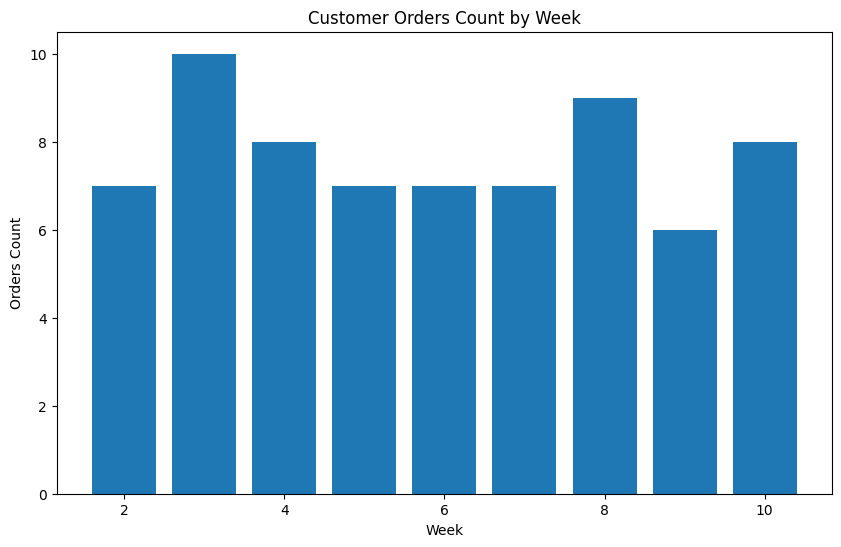

In [ ]:
# number of orders for each customer each week
# shift week to +1 to make it a feature for next week

import matplotlib.pyplot as plt

# Convert the DataFrame to a Pandas DataFrame
customers_orders_lw_pd = customers_orders_lw.toPandas()

# Create a bar graph
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(customers_orders_lw_pd['week'], customers_orders_lw_pd['lw_orders_count'])
ax.set_xlabel('Week')
ax.set_ylabel('Orders Count')
ax.set_title('Customer Orders Count by Week')
plt.show()


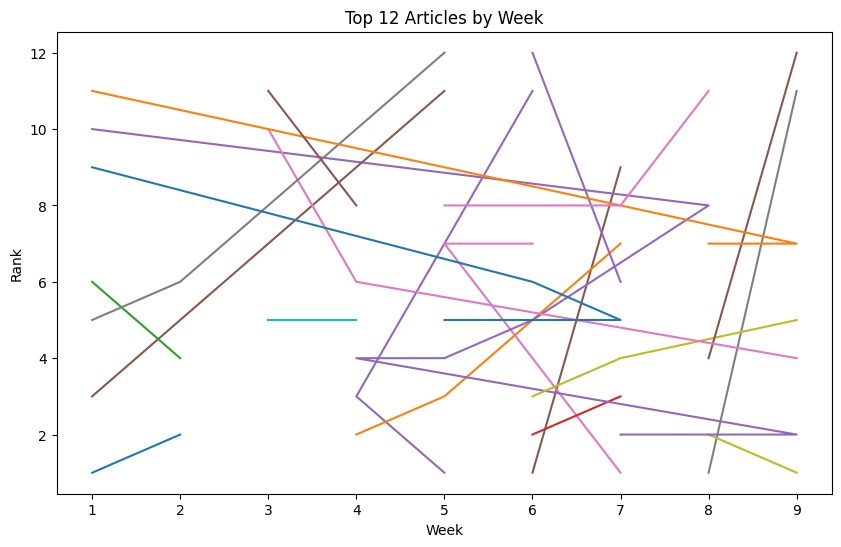

In [ ]:
#rank articles for each week

import matplotlib.pyplot as plt

# Convert the DataFrame to a Pandas DataFrame
articles_rank_pd = articles_rank.toPandas()
articles_top12_pd = articles_top12.toPandas()

# Create a line graph for the top 12 articles for each week
fig, ax = plt.subplots(figsize=(10,6))
for article_id in articles_top12_pd['article_id'].unique():
    data = articles_top12_pd[articles_top12_pd['article_id'] == article_id]
    ax.plot(data['week'], data['rank'], label=article_id)
ax.set_xlabel('Week')
ax.set_ylabel('Rank')
ax.set_title('Top 12 Articles by Week')

plt.show()


In [ ]:
transactions = transactions\
.dropDuplicates()\

transactions.show(10)

+--------------------+----------+----+
|         customer_id|article_id|week|
+--------------------+----------+----+
|e9e62e8120bc9f31c...| 811471001|   5|
|0feafc06f28e4d5cd...| 728156025|   6|
|f85d6bb1cbaae37e4...| 624486061|   7|
|969f97202aca11383...| 778064003|   8|
|7b55754359419c00e...| 904625001|   8|
|70c30221fd88bfec3...| 696587001|   9|
|4fd20fa4ccc486b89...| 875145001|   6|
|bc25b42d4a81d1c60...| 875329004|   5|
|6525bab79e9f51eab...| 803468002|   2|
|3cb083bef451a4387...| 864040001|   6|
+--------------------+----------+----+
only showing top 10 rows



In [ ]:
# the goal of this transfrom is to shift last bought basket to next week in which the customer bought something
# this is done to create negative observations in "next week" (from a copy of last purchased basked)
# because the customer could've skipped some weeks, I need to put a number to each week partition and shift it +1

# add a reference number for customers who bought something in a certain week (somewhat of a transaction identifier)
rn_transactions = transactions\
    .select('customer_id', 'week')\
    .dropDuplicates()

w_transactions = Window.partitionBy('customer_id').orderBy(rn_transactions.week.asc())

# enumerate rows by week partition
rn_transactions = rn_transactions\
    .withColumn('week_rn', F.row_number().over(w_transactions))\
    .select('customer_id', 'week', 'week_rn')\
    .orderBy(['customer_id', 'week'], ascending = True)

rn_transactions.show(10)

rn_transactions0 = rn_transactions.drop('article_id')\
    .withColumnRenamed('week', 'new_week')\
    .dropDuplicates()

# shift rn to next row
# keep week info from rn_transactions0 and join on shifted week_rn

last_purchase = rn_transactions\
    .withColumn('week_rn', F.col('week_rn')+1)\
    .join(rn_transactions0, ['customer_id', 'week_rn'], 'inner')\
    .join(transactions, ['customer_id', 'week'], 'left')\

last_purchase.show(10)

last_purchase = last_purchase\
    .drop('week')\
    .withColumnRenamed('new_week', 'week')\
    .orderBy(['customer_id', 'week'], ascending = True)\
    .select('customer_id', 'article_id', 'week')

last_purchase.show(20)

lp_per_week = last_purchase\
    .groupBy('week').count().orderBy('week', ascending=True)\

lp_per_week.show(10)
lp_per_week.unpersist()
rn_transactions0.unpersist()

+--------------------+----+-------+
|         customer_id|week|week_rn|
+--------------------+----+-------+
|00009d946eec3ea54...|   4|      1|
|0001076e215991bad...|   1|      1|
|0001b0127d3e5ff8d...|   2|      1|
|0001d44dbe7f6c4b3...|   3|      1|
|0002cca4cc68601e8...|   7|      1|
|00039306476aaf41a...|   9|      1|
|0003e867a930d0d68...|   7|      1|
|0003e867a930d0d68...|   9|      2|
|0004852bef85b2af9...|   2|      1|
|000493dd9fc463df1...|   9|      1|
+--------------------+----+-------+
only showing top 10 rows

+--------------------+----+-------+--------+----------+
|         customer_id|week|week_rn|new_week|article_id|
+--------------------+----+-------+--------+----------+
|03222b4b198d82d8b...|   3|      2|       7| 928845001|
|03222b4b198d82d8b...|   3|      2|       7| 863798001|
|096e30392510e967c...|   1|      2|       9| 706016004|
|165bd612b277cbfa7...|   5|      2|       7| 832473003|
|353085ee4430e5d1d...|   2|      2|       4| 852512005|
|3f49561f36a6091ec...|

DataFrame[customer_id: string, new_week: int, week_rn: int]

In [ ]:
transactions_pos = transactions\
    .select('customer_id', 'article_id', 'week')\
    .withColumn('y', F.lit(1))

In [ ]:
last_purchase = last_purchase\
    .join(transactions_pos, ['customer_id', 'article_id', 'week'], 'left')\
    .fillna({'y': 0})\
    .filter(F.col('y').isin(0))\
    .select('customer_id', 'article_id', 'week', 'y')

last_purchase.show(10)

+--------------------+----------+----+---+
|         customer_id|article_id|week|  y|
+--------------------+----------+----+---+
|003ca8034fe32b9ba...| 874546001|   6|  0|
|004d932f7a27ac316...| 783346032|   9|  0|
|005d818153d6573cb...| 816423004|   3|  0|
|00758087d42362242...| 906635003|   3|  0|
|00896a51471298fc6...| 883730002|   9|  0|
|00944aac87d67eb28...| 851400001|   5|  0|
|009a85913aa6f503e...| 296366006|   6|  0|
|00a917a768bc4ae18...| 685816038|   7|  0|
|00ad1651b21f28b4d...| 808246005|   9|  0|
|00c14b7f150c32bad...| 507909030|   6|  0|
+--------------------+----------+----+---+
only showing top 10 rows



In [ ]:
# create negative observations based on top 12 items for each week

articles_top12_pw = articles_top12\
    .withColumn('week', F.col('week')+1)

listona = transactions\
    .select('customer_id', 'week')\
    .dropDuplicates()\
    .join(articles_top12_pw, ['week'], 'left')\
    .join(transactions_pos, ['customer_id', 'article_id', 'week'], 'left')\
    .fillna({'y': 0})\
    .filter(F.col('y').isin(0))\
    .select('customer_id', 'article_id', 'week', 'y')\
    .orderBy('customer_id', 'week')\

listona.show(10)
articles_top12_pw.unpersist()
transactions_pos.unpersist()

+--------------------+----------+----+---+
|         customer_id|article_id|week|  y|
+--------------------+----------+----+---+
|00009d946eec3ea54...| 599580038|   4|  0|
|00009d946eec3ea54...| 599580072|   4|  0|
|00009d946eec3ea54...| 823505001|   4|  0|
|00009d946eec3ea54...| 778064028|   4|  0|
|00009d946eec3ea54...| 351484039|   4|  0|
|00009d946eec3ea54...| 866731001|   4|  0|
|00009d946eec3ea54...| 610776002|   4|  0|
|00009d946eec3ea54...| 559616013|   4|  0|
|00009d946eec3ea54...| 806225002|   4|  0|
|00009d946eec3ea54...| 865594003|   4|  0|
+--------------------+----------+----+---+
only showing top 10 rows



DataFrame[customer_id: string, article_id: int, week: int, y: int]

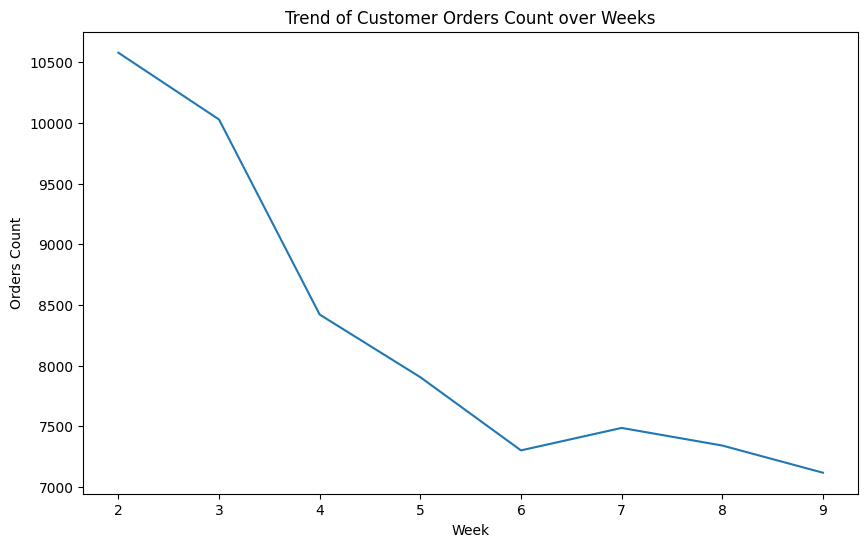

In [ ]:
# exclude from train the most remote week of observation since I don't generate a strategy for it
# join all features

import matplotlib.pyplot as plt

# Convert the DataFrame to a Pandas DataFrame
train_pd = train.toPandas()

# Group by week and calculate the total orders count
orders_by_week = train_pd.groupby('week')['lw_orders_count'].sum()

# Create a line graph
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(orders_by_week.index, orders_by_week.values, label='Orders Count')
ax.set_xlabel('Week')
ax.set_ylabel('Orders Count')
ax.set_title('Trend of Customer Orders Count over Weeks')
plt.show()


In [ ]:
application = spark.read.option("header",True) \
                .csv("/content/drive/MyDrive/sample_submission.csv")

In [ ]:
# top 12 sold from last week
articles_top12_app = articles_top12\
    .filter(F.col('week').isin(max_week))\
    .drop('week')\
    .withColumn('week', F.lit(application_week))\
    .dropDuplicates()

In [ ]:
# top 12 items last week list

top_12 = articles_top12_app.toPandas()
top_12_lw = top_12['article_id'].tolist()

print(top_12_lw)

[762846027, 929275001, 751471001, 923758001, 909370001, 924243001, 573085028, 448509014, 915529003, 924243002, 866731001, 889550002]


In [ ]:
# articles rank feature
last_week_rank = articles_rank\
    .filter(F.col('week').isin(max_week))\
    .drop('week')\
    .withColumn('week', F.lit(application_week))\
    .dropDuplicates()

In [ ]:
#last purchased basket

w_lp = Window.partitionBy('customer_id').orderBy(transactions.week.desc())

last_purchased_app = transactions\
    .select('customer_id', 'week')\
    .dropDuplicates()\
    .withColumn('rn', F.row_number().over(w_lp))\
    .filter(F.col('rn').isin(1))\
    .drop('rn')\
    .join(transactions, ['customer_id', 'week'], 'left')

In [ ]:
application = application\
    .select('customer_id')\
    .join(customers, 'customer_id', 'left')\
    .dropDuplicates()\
    .withColumn('week', F.lit(application_week))\
    .join(articles_top12_app, 'week', 'left')\
    .select('customer_id', 'article_id', 'week')\
    .unionByName(last_purchased_app)\
    .dropDuplicates()\
    .join(customers, 'customer_id', 'left')\
    .join(last_week_rank, 'article_id', 'left')\
    .join(articles, 'article_id', 'left')\
    .join(customers_orders_lw, ['customer_id', 'week'], 'left')\
    .fillna({'rank': 999})\
    .fillna({'lw_orders_count': 0})\
    .drop('week')\
    .dropDuplicates()

application.show(10)

+--------------------+----------+---+----+---------------+-----------------------+-----------------+-------------------------+-------------+--------------+----------+----------------+---------------+
|         customer_id|article_id|age|rank|product_type_no|graphical_appearance_no|colour_group_code|perceived_colour_value_id|department_no|index_group_no|section_no|garment_group_no|lw_orders_count|
+--------------------+----------+---+----+---------------+-----------------------+-----------------+-------------------------+-------------+--------------+----------+----------------+---------------+
|000064249685c1155...| 924243001| 25|   1|            252|                1010016|               13|                        1|         1626|             1|        15|            1003|              0|
|000064249685c1155...| 751471001| 25|   2|            272|                1010016|                9|                        4|         1722|             1|        15|            1009|              0|


In [ ]:
import gc
last_week_rank.unpersist()
articles_top12_app.unpersist()
last_purchased_app.unpersist()

transactions.unpersist()
customers.unpersist()
articles.unpersist()

gc.collect()

350

In [ ]:
import pandas as pd
import gc

train.repartition(1).write.mode('overwrite').csv('/content/drive/MyDrive/train_df', header='true')

train.unpersist()
gc.collect()

AttributeError: ignored

In [ ]:
import os
print(os.listdir("../"))
print(os.listdir("../content/drive/MyDrive/train_df"))

['srv', 'etc', 'tmp', 'lib32', 'sys', 'lib', 'root', 'opt', 'var', 'media', 'bin', 'dev', 'home', 'run', 'usr', 'libx32', 'sbin', 'boot', 'lib64', 'mnt', 'proc', 'content', 'kaggle', '.dockerenv', 'tools', 'datalab', 'python-apt', 'NGC-DL-CONTAINER-LICENSE']
['part-00000-a8cb84bf-877c-4a19-ba59-265c323e40f8-c000.csv', '.part-00000-a8cb84bf-877c-4a19-ba59-265c323e40f8-c000.csv.crc', '_SUCCESS', '._SUCCESS.crc']


In [ ]:
path_t = os.listdir("../content/drive/MyDrive/train_df")
trim_t = [x for x in path_t if x.startswith('part')]
stringa_t = ''.join(trim_t)
train_path = '../content/drive/MyDrive/train_df/'+stringa_t

print(train_path)

../content/drive/MyDrive/train_df/part-00000-a8cb84bf-877c-4a19-ba59-265c323e40f8-c000.csv


In [ ]:
# save application
application.repartition(1).write.mode('overwrite').csv('/kaggle/working/application', header = 'true')

application.unpersist()

DataFrame[customer_id: string, article_id: int, age: string, rank: int, product_type_no: int, graphical_appearance_no: int, colour_group_code: int, perceived_colour_value_id: int, department_no: int, index_group_no: int, section_no: int, garment_group_no: int, lw_orders_count: bigint]

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm.sklearn import LGBMRanker

train = pd.read_csv(train_path)
train.sort_values(['week', 'customer_id'], inplace=True)
train.reset_index(drop=True, inplace=True)
print('train:', train.shape)

train: (1253285, 15)


In [ ]:
import re
#train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
# columns renamed because for some reason one hot encoding creates invalid characters
train_cols = list(train.columns)
print(train_cols)

['customer_id', 'week', 'article_id', 'y', 'age', 'rank', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id', 'department_no', 'index_group_no', 'section_no', 'garment_group_no', 'lw_orders_count']


In [ ]:
qids_train = train.groupby(['week', 'customer_id'])['article_id'].count().values

X_train = train.drop(["y", 'customer_id', 'week'], axis=1)
y_train = train["y"]

In [ ]:
print(qids_train)

[13 13 13 ... 16 14 14]


In [ ]:
# Number of estimators is recommended as default to 100 by documentation

model = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=100,
    importance_type='gain',
    verbose=10,
    random_state = 17
)

model.fit(
    X=X_train,
    y=y_train,
    group=qids_train,
)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.838167
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.193689
[LightGBM] [Debug] init for col-wise cost 0.029106 seconds, init for row-wise cost 0.065399 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 801
[LightGBM] [Info] Number of data points in the train set: 1253285, number of used features: 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] 

LGBMRanker(boosting_type='dart', importance_type='gain', metric='ndcg',
           objective='lambdarank', random_state=17, verbose=10)

In [ ]:
# feature importance
x_train_cols = list(X_train.columns)

for i in model.feature_importances_.argsort()[::-1]:
    print(x_train_cols[i], model.feature_importances_[i]/model.feature_importances_.sum())

article_id 0.3301881198516759
colour_group_code 0.1361823064649362
product_type_no 0.10634664850527847
rank 0.09763897836406964
department_no 0.09312807449733615
section_no 0.07119598531903487
graphical_appearance_no 0.06994892415256618
perceived_colour_value_id 0.04385866849600829
garment_group_no 0.040567734999677495
index_group_no 0.01094455934941682
lw_orders_count 0.0
age 0.0


In [ ]:
import numpy as np

unique_qids_train, counts = np.unique(qids_train[np.isin(qids_train, np.unique(qids_train))], return_counts=True)
print(f"Number of unique queries in training set: {len(unique_qids_train)}")


Number of unique queries in training set: 14


In [ ]:
unique_qids_train = np.unique(qids_train)
mask = np.isin(qids_train, unique_qids_train)
mask = np.repeat(mask, 5)
y_train_filtered = y_train
qids_train_filtered = qids_train


In [ ]:
print(os.listdir("../"))
print(os.listdir("../content/drive/MyDrive/application"))

['srv', 'etc', 'tmp', 'lib32', 'sys', 'lib', 'root', 'opt', 'var', 'media', 'bin', 'dev', 'home', 'run', 'usr', 'libx32', 'sbin', 'boot', 'lib64', 'mnt', 'proc', 'content', 'kaggle', '.dockerenv', 'tools', 'datalab', 'python-apt', 'NGC-DL-CONTAINER-LICENSE']
['._SUCCESS.crc', '_SUCCESS', 'part-00000-00bea898-439d-41c9-898b-c349e604e162-c000.csv', 'untitled', 'SSSS']


In [ ]:
path = os.listdir("../content/drive/MyDrive/application")
trim = [x for x in path if x.startswith('part')]
stringa = ''.join(trim)
app_path = '../content/drive/MyDrive/application/'+stringa

print(app_path)

../content/drive/MyDrive/application/part-00000-00bea898-439d-41c9-898b-c349e604e162-c000.csv


In [ ]:
application = pd.read_csv(app_path)
application.sort_values('customer_id', inplace=True)
application.reset_index(drop=True, inplace=True)

application_x = application.drop('customer_id', axis = 1)
print('application_x:', application_x.shape)
app_cols = list(application_x.columns)
print(app_cols)

application_x: (17742686, 12)
['article_id', 'age', 'rank', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id', 'department_no', 'index_group_no', 'section_no', 'garment_group_no', 'lw_orders_count']


In [ ]:
application['prediction'] = model.predict(application_x)

In [ ]:
pred_dict = application \
    .sort_values(['customer_id', 'prediction'], ascending=False) \
    .groupby('customer_id')['article_id'].apply(list).to_dict()

In [ ]:
sub = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')

In [ ]:
preds = []
for c_id in sub.customer_id:
    pred = pred_dict.get(c_id, [])
    pred = pred + top_12_lw
    preds.append(pred[:12])
    

In [ ]:
preds = [' '.join(['0' + str(p) for p in ps]) for ps in preds]
sub.prediction = preds

In [ ]:
sub_name = 'submission'
sub.to_csv(f'{sub_name}.csv', index=False)